### NoProp

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Configurações
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
num_classes = 10
embedding_dim = 20
T = 5  # número de passos de difusão
alpha_t = [0.7 ** t for t in range(T + 1)]  # escala de ruído decrescente

# Dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=64, shuffle=True)

# Embedding de classe (WEmbed)
W_embed = nn.Embedding(num_classes, embedding_dim)
with torch.no_grad():
    W_embed.weight.copy_(torch.eye(num_classes, embedding_dim))  # vetor one-hot
W_embed = W_embed.to(device)

# Modelo de denoising para cada camada
class DenoiseLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.img_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU()
        )
        self.z_fc = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU()
        )
        self.out = nn.Linear(256, embedding_dim)

    def forward(self, x, z):
        img_feat = self.img_fc(x)
        z_feat = self.z_fc(z)
        h = torch.cat([img_feat, z_feat], dim=1)
        return self.out(h)

# Inicializa camadas e otimizadores
layers = [DenoiseLayer().to(device) for _ in range(T)]
optimizers = [torch.optim.Adam(layer.parameters(), lr=1e-3) for layer in layers]

# Treinamento camada a camada
for t in range(T):
    print(f"Treinando camada {t+1}/{T}")
    layer = layers[t]
    optimizer = optimizers[t]

    for epoch in range(1):  # 1 época por simplicidade
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            u_y = W_embed(y)

            # Adiciona ruído ao embedding do rótulo
            noise = torch.randn_like(u_y)
            alpha = alpha_t[t + 1]
            alpha_tensor = torch.tensor(alpha, dtype=u_y.dtype, device=u_y.device)
            z_t = torch.sqrt(alpha_tensor) * u_y + torch.sqrt(1 - alpha_tensor) * noise

            # Previsão do denoised
            z_pred = layer(x, z_t)

            # Loss: L2 entre previsão e embedding original
            loss = F.mse_loss(z_pred, u_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# Inferência: aplica as camadas em sequência para denoiser ruído
def predict(x):
    z = torch.randn(x.shape[0], embedding_dim).to(device)
    for layer in layers:
        z = layer(x, z)
    logits = F.linear(z, W_embed.weight)  # produto escalar com os embeddings
    return logits.argmax(dim=1)

# Avaliação no conjunto de teste
test_loader = DataLoader(datasets.MNIST(root='./data', train=False, transform=transform),
                         batch_size=1000, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_hat = predict(x)
        correct += (y_hat == y).sum().item()
        total += y.size(0)

print(f"Acurácia de teste (NoProp-DT): {correct / total * 100:.2f}%")

Treinando camada 1/5
Treinando camada 2/5
Treinando camada 3/5
Treinando camada 4/5
Treinando camada 5/5
Acurácia de teste (NoProp-DT): 93.37%


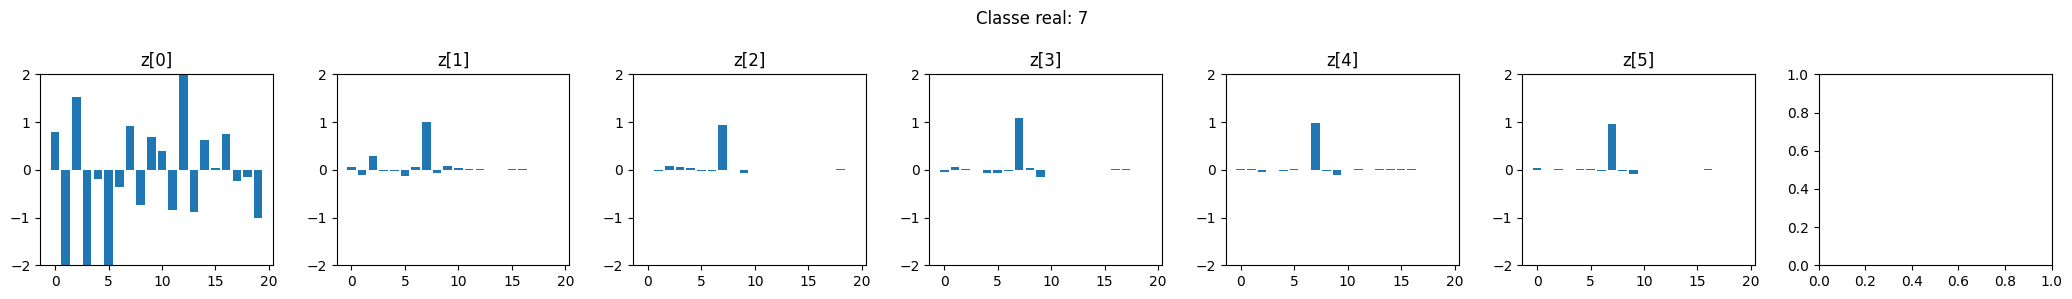

Output()

In [3]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Escolhe uma imagem da base de teste
test_images, test_labels = next(iter(test_loader))
test_images = test_images.to(device)
test_labels = test_labels.to(device)

def sasha_visualizador(img_idx=0):
    x = test_images[img_idx].unsqueeze(0)  # imagem 1x28x28
    y = test_labels[img_idx].item()

    z_values = []
    z = torch.randn(1, embedding_dim).to(device)
    z_values.append(z.cpu().numpy().flatten())

    for layer in layers:
        z = layer(x, z)
        z_values.append(z.detach().cpu().numpy().flatten())

    fig, axs = plt.subplots(1, T+2, figsize=(3*(T+2), 3))
    for i, z_vec in enumerate(z_values):
        axs[i].bar(range(embedding_dim), z_vec)
        axs[i].set_ylim(-2, 2)
        axs[i].set_title(f"z{[i]}")

    plt.suptitle(f"Classe real: {y}")
    plt.tight_layout()
    plt.show()

# Widget interativo
img_slider = widgets.IntSlider(min=0, max=len(test_images)-1, step=1, value=0, description='Imagem')
ui = widgets.HBox([img_slider])
out = widgets.interactive_output(sasha_visualizador, {'img_idx': img_slider})

display(ui, out)


Digite o índice da imagem [0 - 999] ou -1 para sair:  769


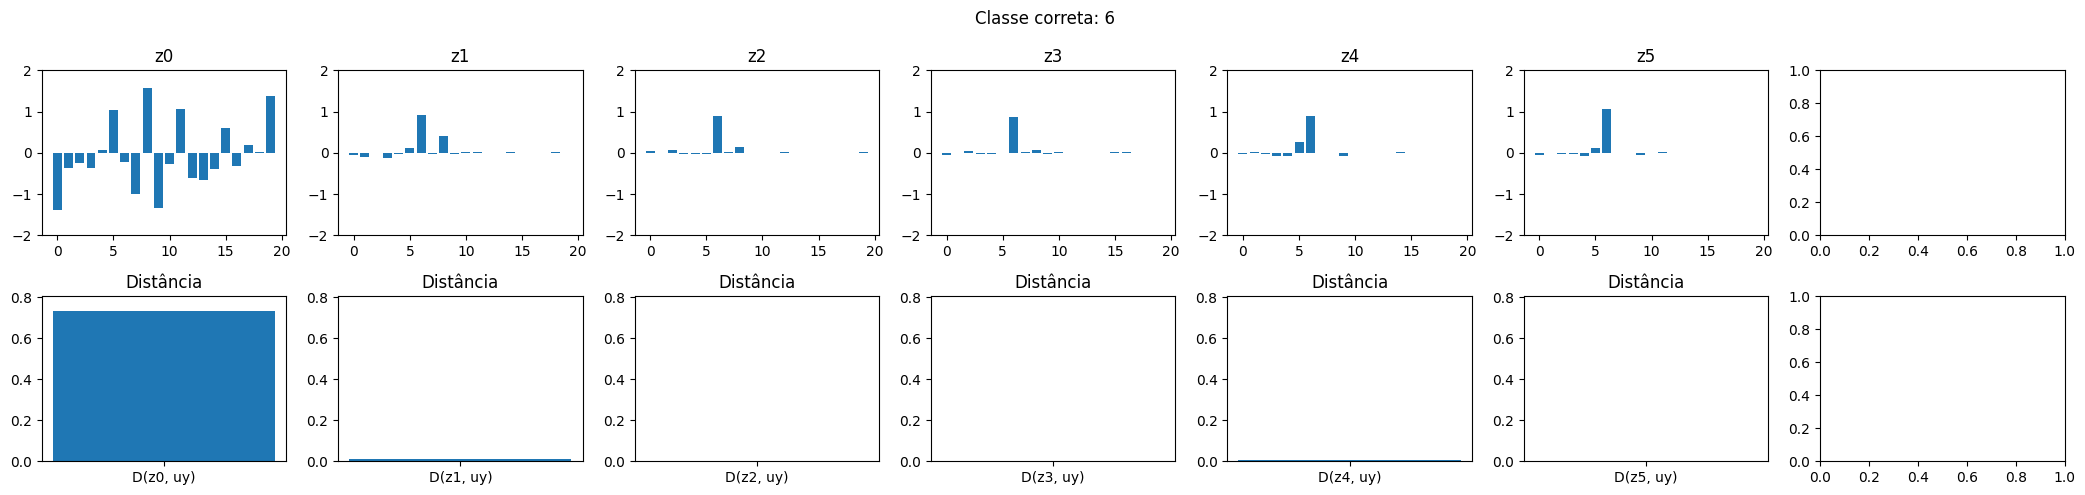


Digite o índice da imagem [0 - 999] ou -1 para sair:  770


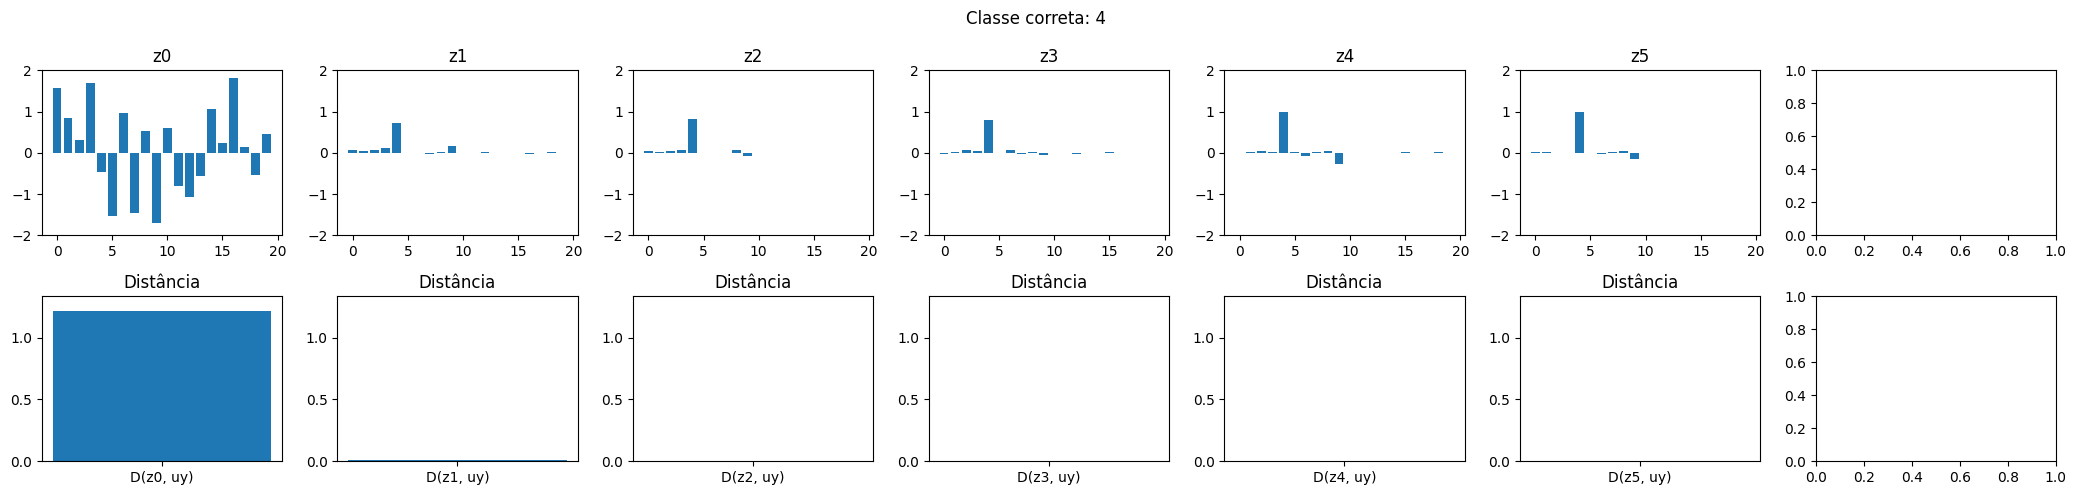


Digite o índice da imagem [0 - 999] ou -1 para sair:  1000


Índice fora do intervalo.



Digite o índice da imagem [0 - 999] ou -1 para sair:  999


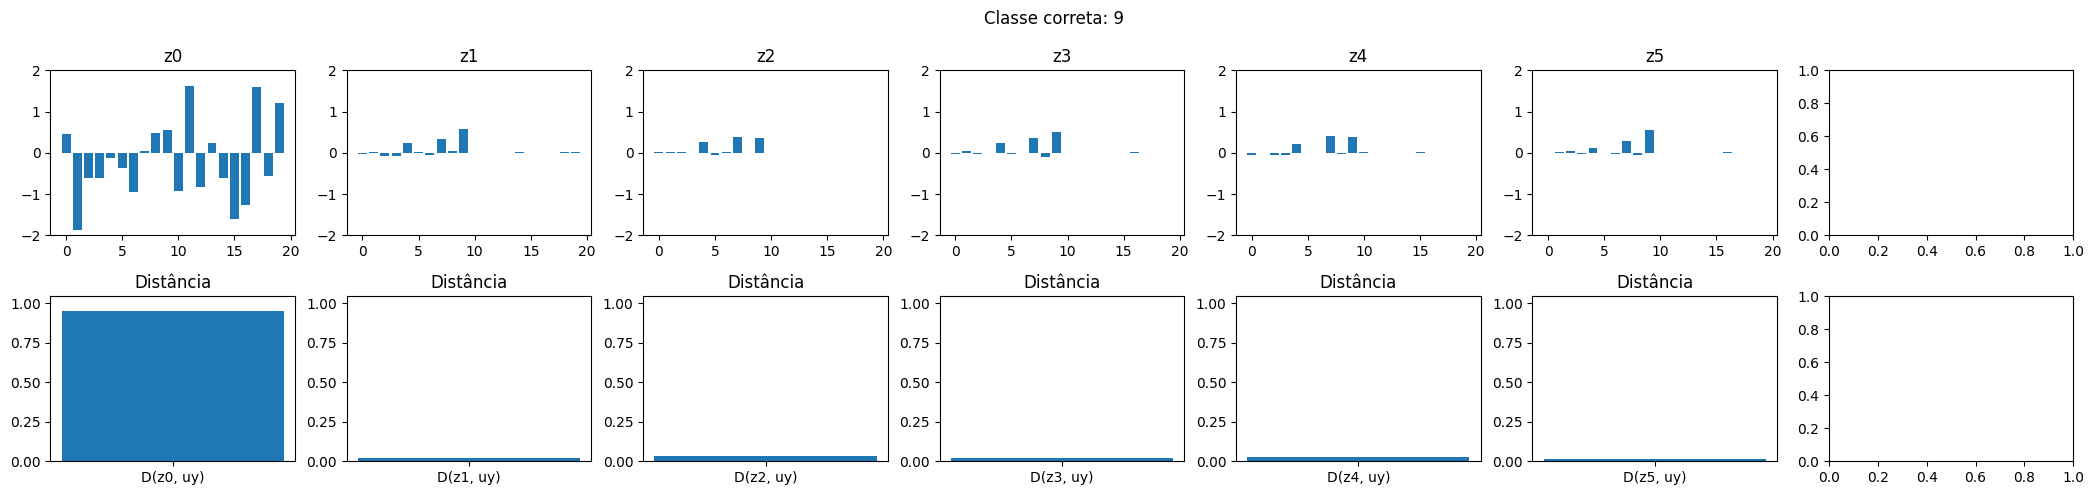


Digite o índice da imagem [0 - 999] ou -1 para sair:  998


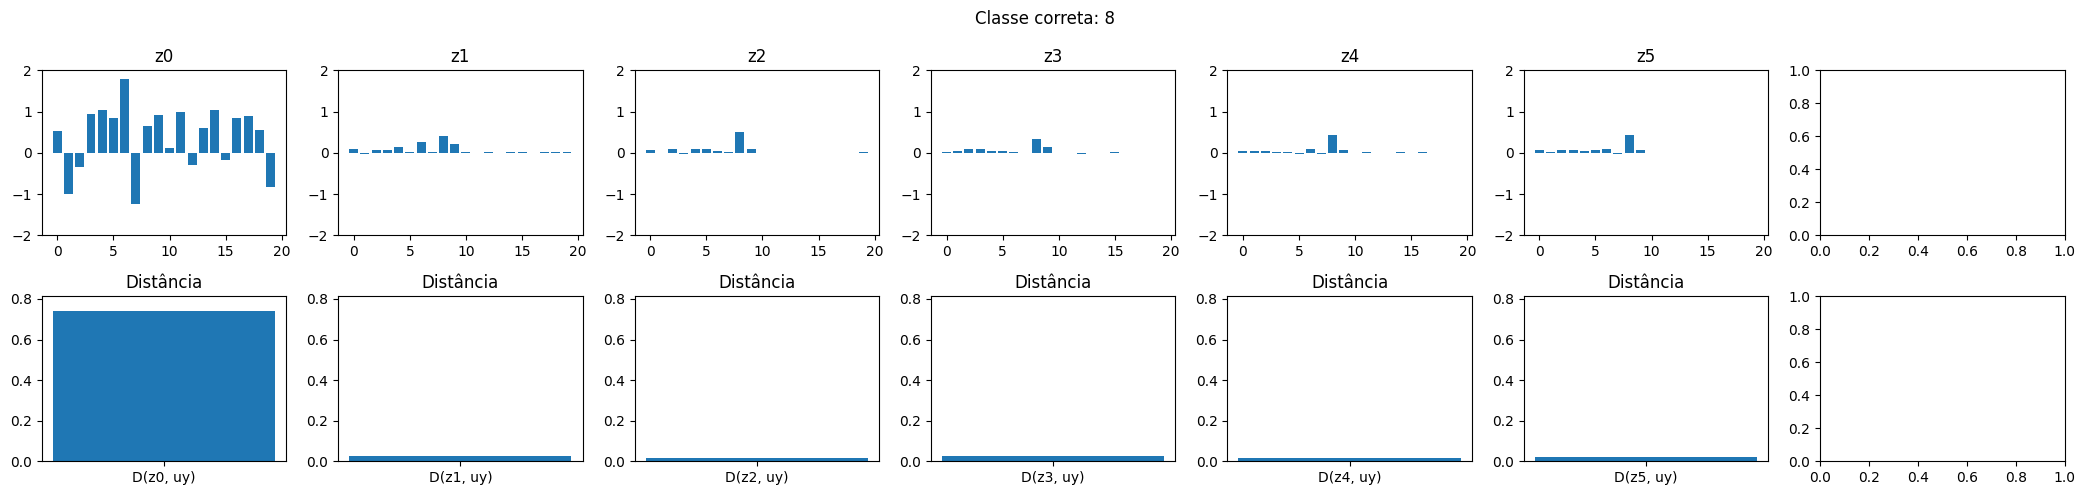


Digite o índice da imagem [0 - 999] ou -1 para sair:  778


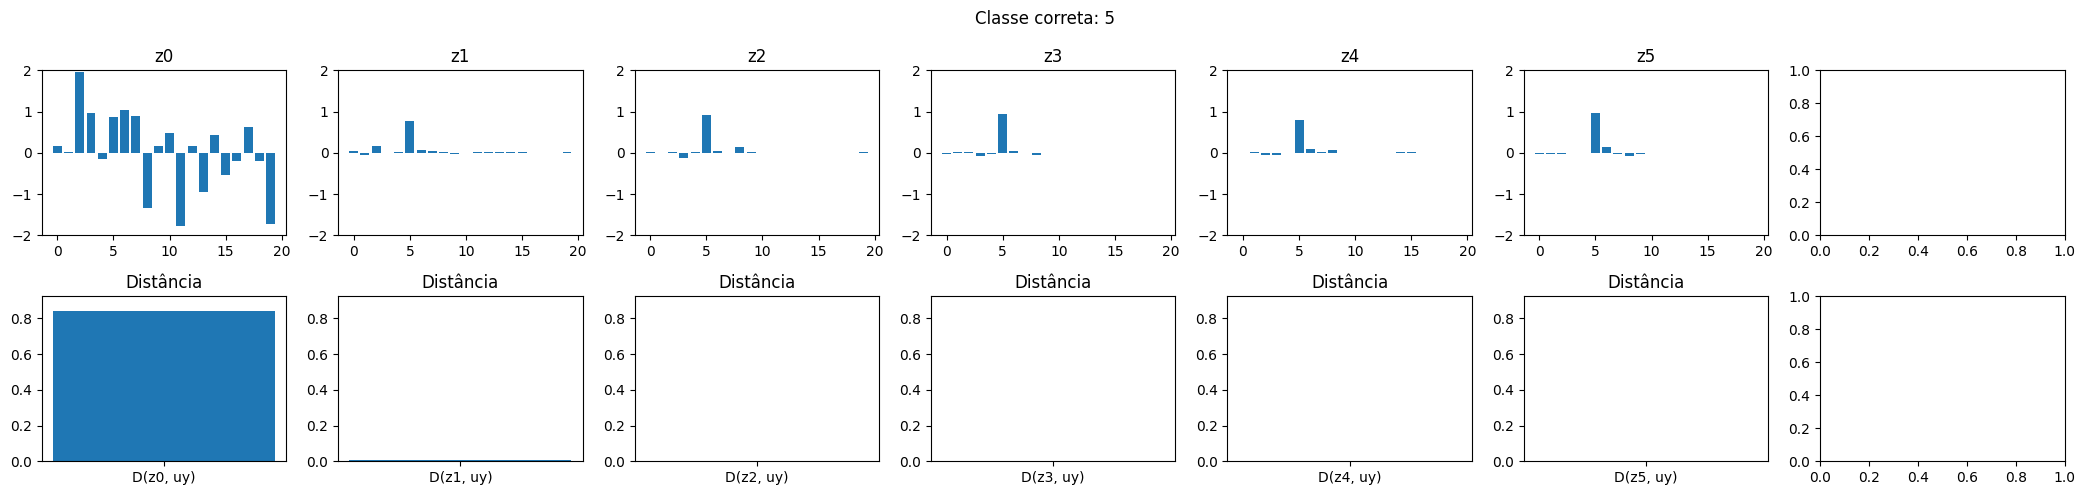


Digite o índice da imagem [0 - 999] ou -1 para sair:  50000000000000


Índice fora do intervalo.



Digite o índice da imagem [0 - 999] ou -1 para sair:  5


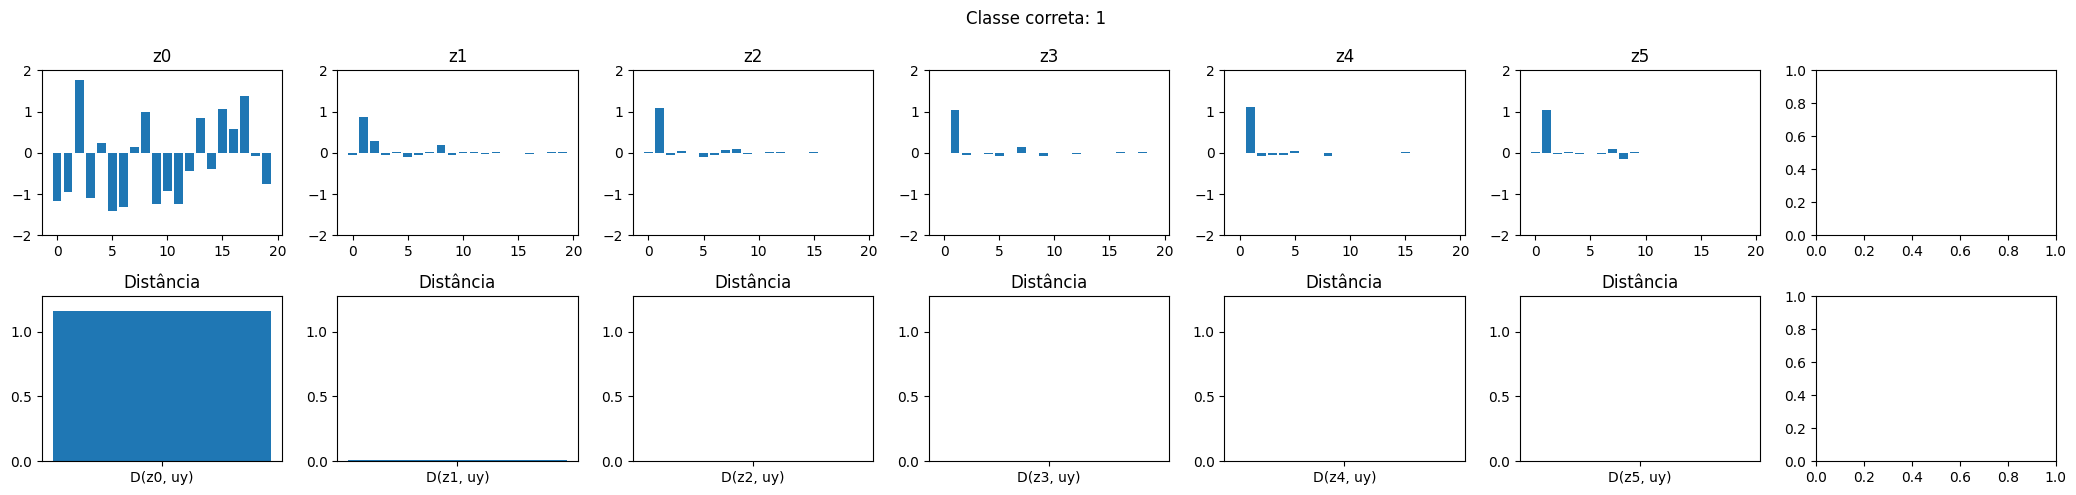


Digite o índice da imagem [0 - 999] ou -1 para sair:  2


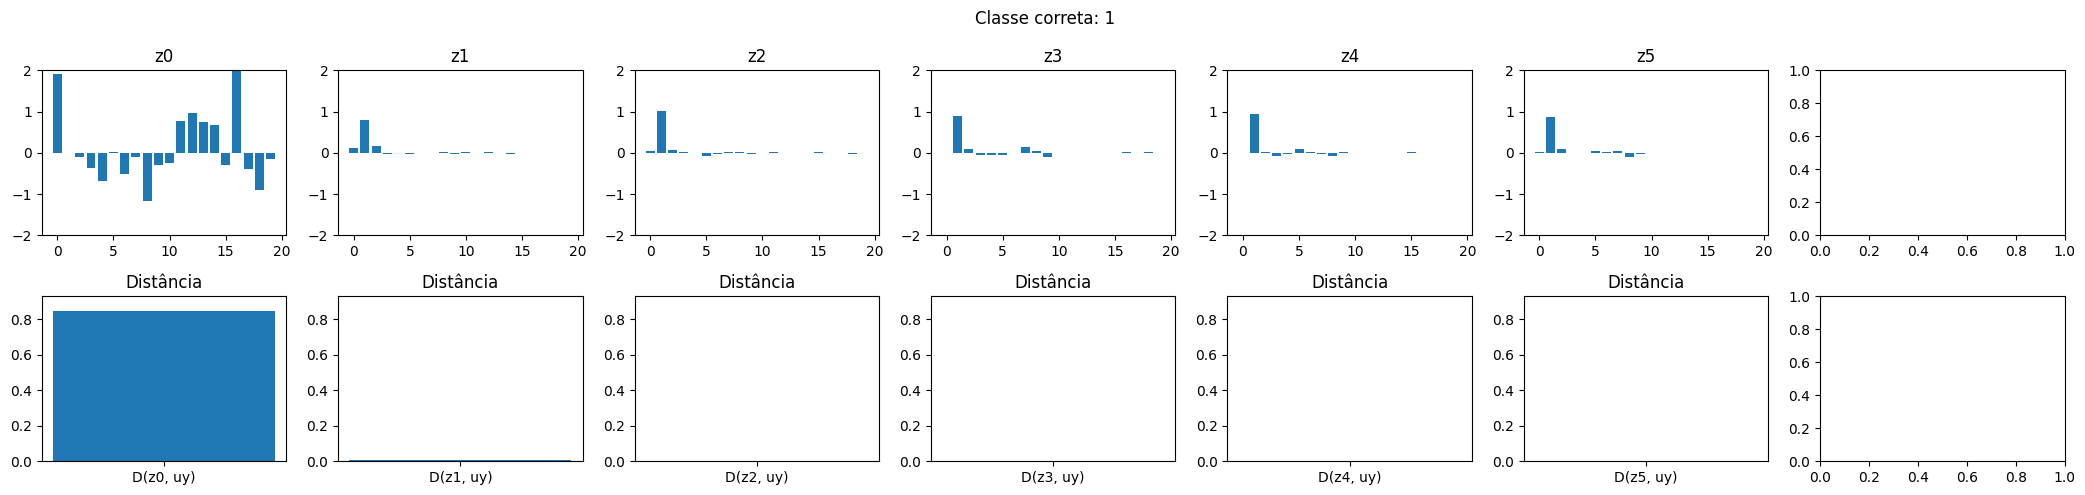


Digite o índice da imagem [0 - 999] ou -1 para sair:  1


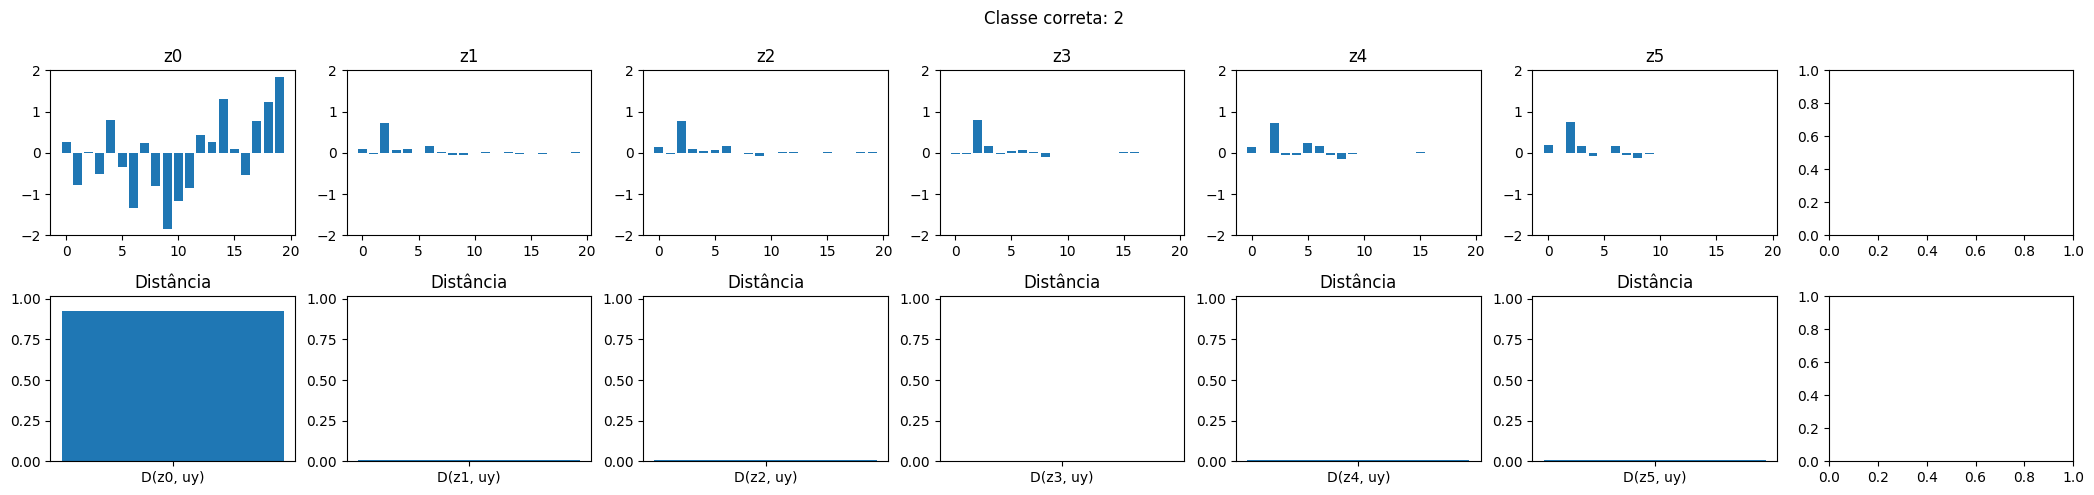


Digite o índice da imagem [0 - 999] ou -1 para sair:  -3


Índice fora do intervalo.



Digite o índice da imagem [0 - 999] ou -1 para sair:  50


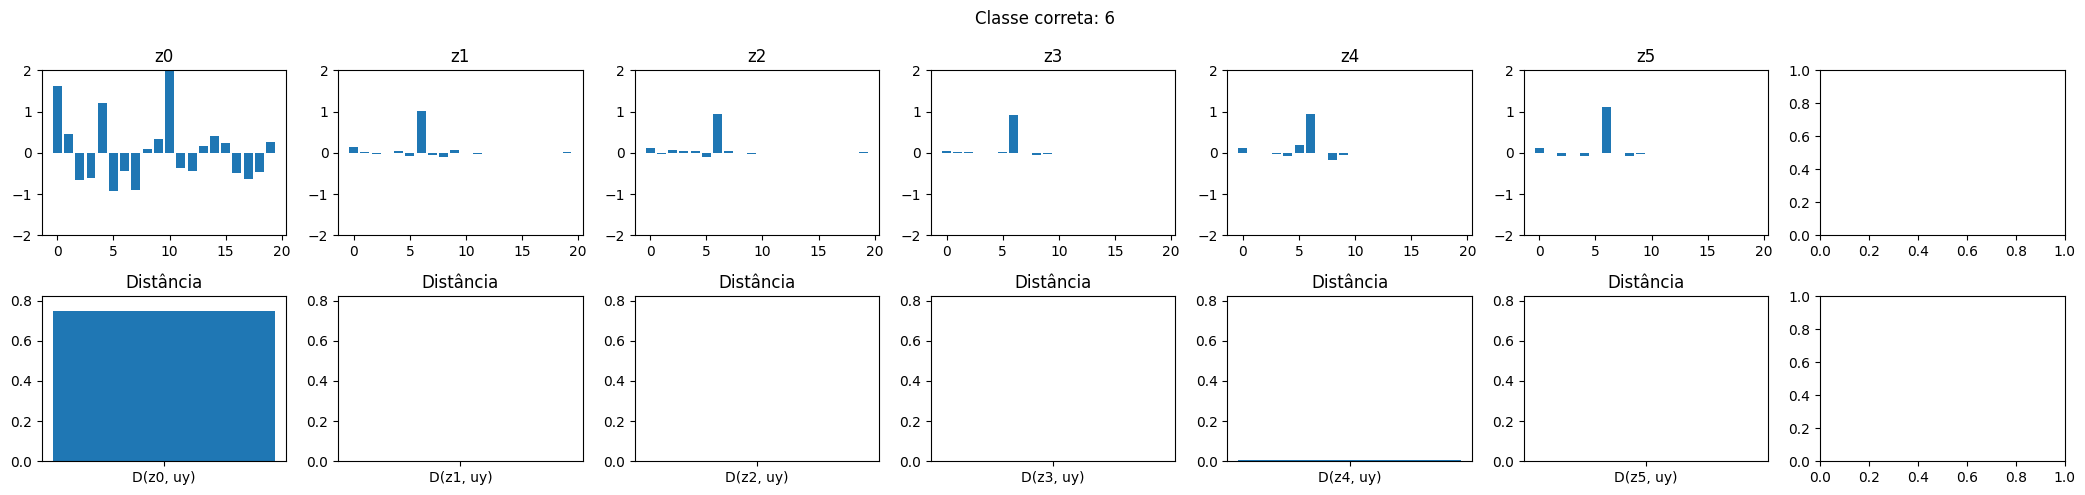


Digite o índice da imagem [0 - 999] ou -1 para sair:  100


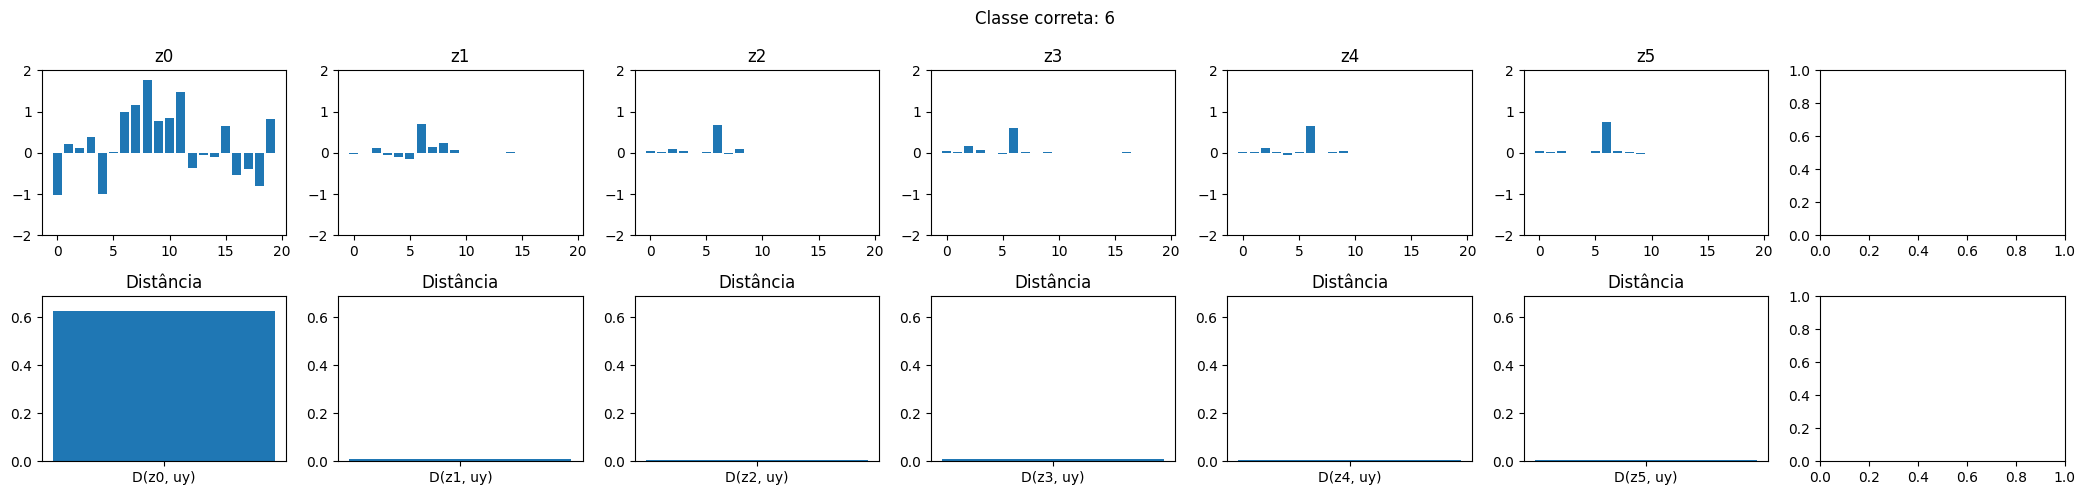


Digite o índice da imagem [0 - 999] ou -1 para sair:  200


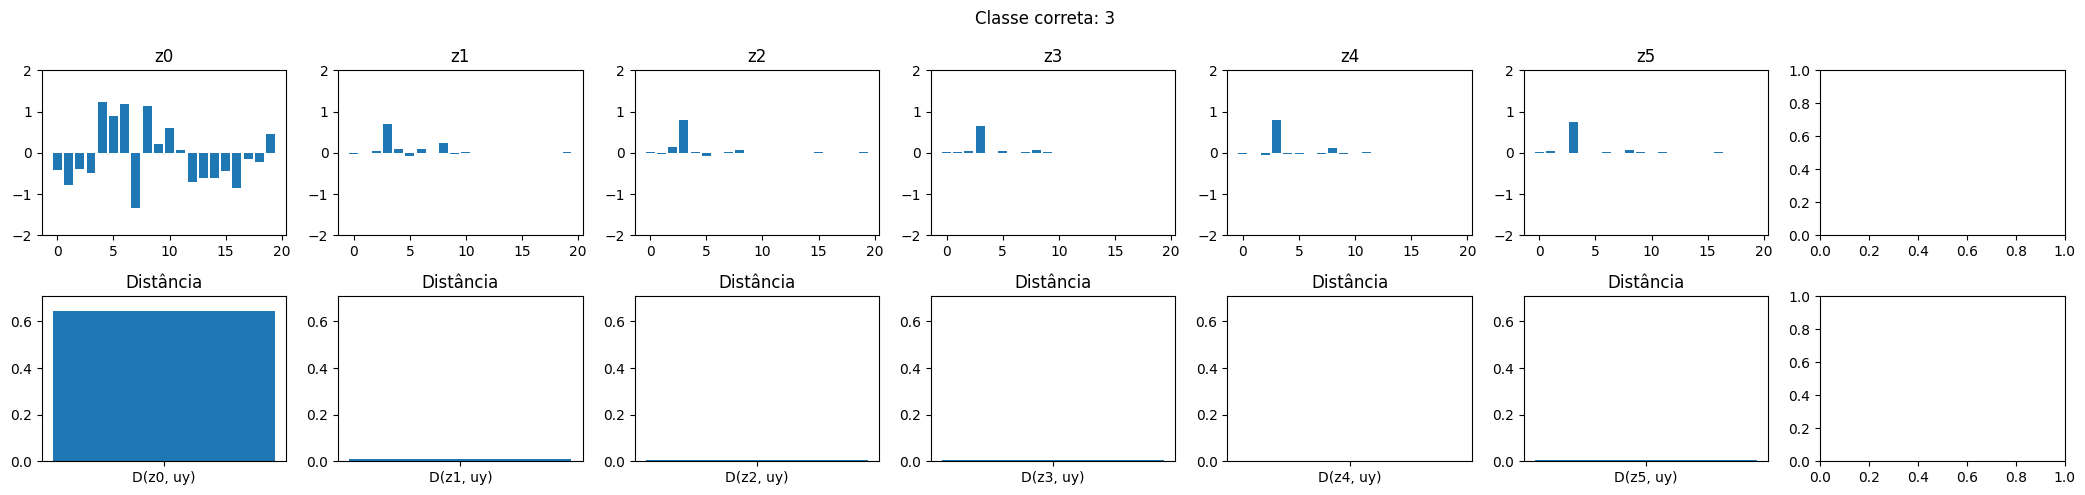

KeyboardInterrupt: Interrupted by user

In [5]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def sasha_avancado(idx: int):
    # Seleciona imagem e label
    x = test_images[idx].unsqueeze(0)  # 1x1x28x28
    y = test_labels[idx].item()
    u_y = W_embed(torch.tensor([y], device=device))  # vetor da classe correta

    # Inicia z0 como ruído
    z = torch.randn(1, embedding_dim).to(device)
    z_values = [z.cpu().numpy().flatten()]
    dists = [F.mse_loss(z, u_y).item()]  # distância inicial

    # Propaga camada por camada
    for layer in layers:
        z = layer(x, z)
        z_values.append(z.detach().cpu().numpy().flatten())
        dists.append(F.mse_loss(z, u_y).item())

    # Plot
    fig, axs = plt.subplots(2, T+2, figsize=(3*(T+2), 5))

    for i, (z_vec, dist) in enumerate(zip(z_values, dists)):
        axs[0, i].bar(range(embedding_dim), z_vec)
        axs[0, i].set_ylim(-2, 2)
        axs[0, i].set_title(f"z{i}")
        
        axs[1, i].bar([0], [dist])
        axs[1, i].set_ylim(0, max(dists)*1.1)
        axs[1, i].set_xticks([0])
        axs[1, i].set_xticklabels([f"D(z{i}, uy)"])
        axs[1, i].set_title("Distância")

    plt.suptitle(f"Classe correta: {y}")
    plt.tight_layout()
    plt.show()

# Executar com input manual
while True:
    try:
        idx = int(input(f"\nDigite o índice da imagem [0 - {len(test_images)-1}] ou -1 para sair: "))
        if idx == -1:
            print("Encerrado.")
            break
        elif 0 <= idx < len(test_images):
            sasha_avancado(idx)
        else:
            print("Índice fora do intervalo.")
    except ValueError:
        print("Digite um número inteiro válido.")



Treinando camada 1/5

Treinando camada 2/5

Treinando camada 3/5

Treinando camada 4/5

Treinando camada 5/5


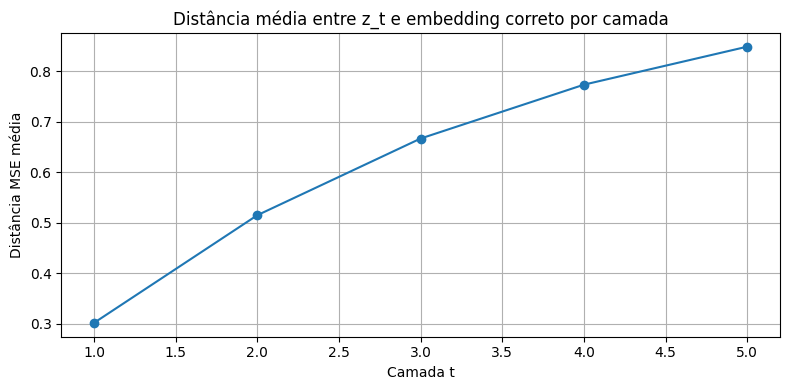

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Configurações
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
num_classes = 10
embedding_dim = 20
T = 5
alpha_t = [0.7 ** t for t in range(T + 1)]

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=64, shuffle=True)

# Embeddings
W_embed = nn.Embedding(num_classes, embedding_dim)
with torch.no_grad():
    W_embed.weight.copy_(torch.eye(num_classes, embedding_dim))
W_embed = W_embed.to(device)

# Modelo
class DenoiseLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.img_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU()
        )
        self.z_fc = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU()
        )
        self.out = nn.Linear(256, embedding_dim)

    def forward(self, x, z):
        img_feat = self.img_fc(x)
        z_feat = self.z_fc(z)
        h = torch.cat([img_feat, z_feat], dim=1)
        return self.out(h)

# Inicializa
layers = [DenoiseLayer().to(device) for _ in range(T)]
optimizers = [torch.optim.Adam(layer.parameters(), lr=1e-3) for layer in layers]

# Salva distância média por camada
energy_per_step = []

# Treinamento
for t in range(T):
    print(f"\nTreinando camada {t+1}/{T}")
    layer = layers[t]
    optimizer = optimizers[t]
    distances = []

    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        u_y = W_embed(y)
        noise = torch.randn_like(u_y)
        alpha = alpha_t[t + 1]
        alpha_tensor = torch.tensor(alpha, dtype=u_y.dtype, device=u_y.device)
        z_t = torch.sqrt(alpha_tensor) * u_y + torch.sqrt(1 - alpha_tensor) * noise

        # Métrica de energia = distância até o embedding verdadeiro
        dist = F.mse_loss(z_t, u_y, reduction='none').mean(dim=1)  # vetor por amostra
        distances.append(dist.mean().item())

        z_pred = layer(x, z_t)
        loss = F.mse_loss(z_pred, u_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i >= 100:  # Limita para acelerar visualização
            break

    # Salva distância média da camada
    energy_per_step.append(sum(distances) / len(distances))

# Plot da energia (distância ao embedding correto) ao longo das camadas
plt.figure(figsize=(8, 4))
plt.plot(range(1, T + 1), energy_per_step, marker='o')
plt.title('Distância média entre z_t e embedding correto por camada')
plt.xlabel('Camada t')
plt.ylabel('Distância MSE média')
plt.grid(True)
plt.tight_layout()
plt.show()


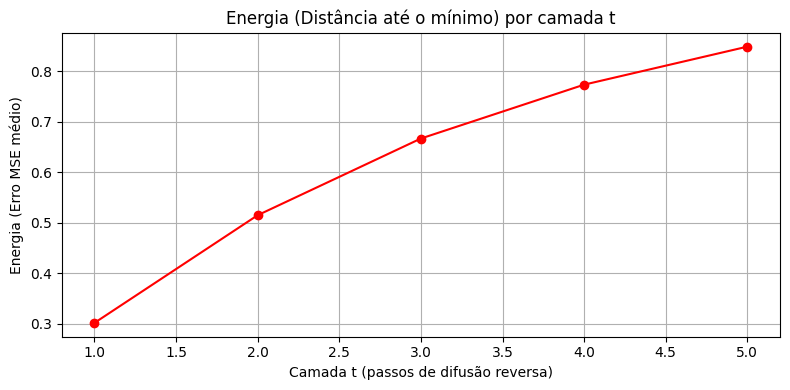

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, T + 1), energy_per_step, marker='o', color='red')
plt.title('Energia (Distância até o mínimo) por camada t')
plt.xlabel('Camada t (passos de difusão reversa)')
plt.ylabel('Energia (Erro MSE médio)')
plt.grid(True)
plt.tight_layout()
plt.show()


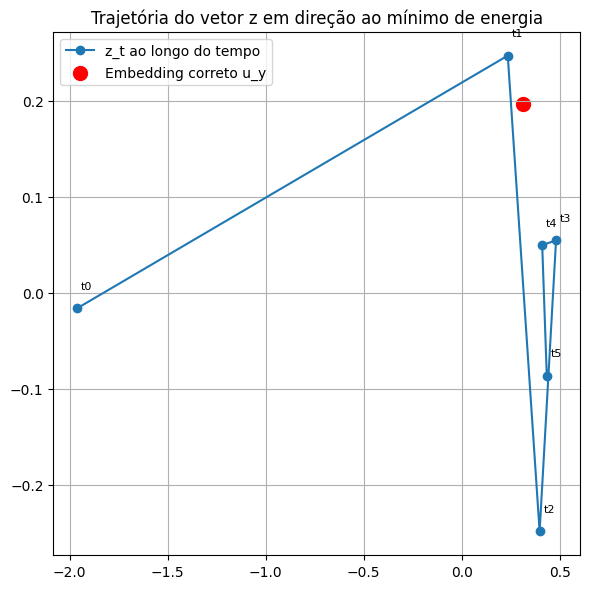

In [119]:
def visualizar_dinamica_energia(layers, W_embed, x, y):
    x, y = x.to(device), y.to(device)
    u_y = W_embed(y)  # vetor correto
    alpha = alpha_t[1]
    z_t = torch.sqrt(torch.tensor(alpha)).to(device) * u_y + \
          torch.sqrt(torch.tensor(1 - alpha)).to(device) * torch.randn_like(u_y)

    traj = [z_t.cpu()]
    z = z_t
    for layer in layers:
        z = layer(x, z)
        traj.append(z.cpu())

    traj_tensor = torch.stack(traj).squeeze(1).detach().numpy()  # (T+1, D)
    u_y_tensor = u_y.cpu().squeeze(0).detach().numpy()  # (D,)

    # PCA apenas com a trajetória
    pca = PCA(n_components=2)
    traj_2d = pca.fit_transform(traj_tensor)
    u_y_2d = pca.transform(u_y_tensor.reshape(1, -1))[0]

    # Plotagem
    plt.figure(figsize=(6, 6))
    plt.plot(traj_2d[:, 0], traj_2d[:, 1], marker='o', label='z_t ao longo do tempo')
    plt.scatter(*u_y_2d, c='red', s=100, label='Embedding correto u_y')
    for i, (x_, y_) in enumerate(traj_2d):
        plt.text(x_ + 0.02, y_ + 0.02, f"t{i}", fontsize=8)
    plt.title("Trajetória do vetor z em direção ao mínimo de energia")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Teste
x_demo, y_demo = next(iter(loader))
visualizar_dinamica_energia(layers, W_embed, x_demo[:1], y_demo[:1])
